In [18]:
import pickle as pkl
import pandas as pd
import numpy as np
import os
import json
from tqdm import tqdm
tqdm.pandas()
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pickle
import nltk
from collections import Counter
sns.set_palette("colorblind")

## Plot Dataset specific and total plots

In [2]:
data_path = "/zfs/projects/faculty/amirgo-management/code_review_data/pooling/"
df = pd.read_csv(data_path + "implicit_trend.csv")

/tmp/ipykernel_3182760/3953407079.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path + "implicit_trend.csv")


In [3]:
df = df.loc[(df['year'] >=1950) & (df['year'] <= 2017)]

In [4]:
def get_plot_data(fig):
    ax = fig.axes[0] # access the first and only axis
    # ax = fig.axes
    x_data = ax.lines[0].get_xdata()
    y_data = ax.axes.lines[0].get_ydata()
    confidence_dict = {}
    for i in range(len(x_data)):
        confidence_dict[x_data[i]] = []

    # confidence interval
    confidence_shape = ax.collections[0].get_paths()[0].vertices
    for i in range(len(confidence_shape)):
        year = confidence_shape[i][0]
        value = confidence_shape[i][1]
        if value not in confidence_dict[year]:
            confidence_dict[year].append(value)
    # sort the confidence interval
    for year in confidence_dict:
        confidence_dict[year].sort()
        
    # covert to a single df
    x_data = x_data.tolist()
    y_data = y_data.tolist()
    ci_lower = [confidence_dict[x_data[i]][0] for i in range(len(x_data))]
    ci_upper = [confidence_dict[x_data[i]][1] for i in range(len(x_data))]
    plot_df = pd.DataFrame({'year': x_data, 'y': y_data, 'ci_lower': ci_lower, 'ci_upper': ci_upper})

    # add smoothed data
    plot_df['y_smooth'] = plot_df['y'].rolling(window=10, min_periods=1).mean()
    plot_df['ci_lower_smooth'] = plot_df['ci_lower'].rolling(window=10, min_periods=1).mean()
    plot_df['ci_upper_smooth'] = plot_df['ci_upper'].rolling(window=10, min_periods=1).mean()

    # normalize the data
    y_min = min(plot_df['y_smooth'])
    y_max = max(plot_df['y_smooth'])
    plot_df['y_norm'] = (plot_df['y_smooth'] - y_min) / (y_max - y_min)
    plot_df['ci_lower_norm'] = (plot_df['ci_lower_smooth'] - y_min) / (y_max - y_min)
    plot_df['ci_upper_norm'] = (plot_df['ci_upper_smooth'] - y_min) / (y_max - y_min)
    
    return plot_df

In [5]:
plot_dfs = []
datasets = list(df['dataset'].unique())
datasets.append('total')

for dataset in tqdm(datasets):
    print("Processing dataset: ", dataset)
    if dataset != 'total':
        df_dataset = df[df['dataset'] == dataset].copy()
    else:
        df_dataset = df.copy()

    # normalize the data
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.lineplot(x='year', y='subgroup_orig_syn_ratio', data=df_dataset, ax=ax)

    plot_df = get_plot_data(fig)
    plot_df['dataset'] = dataset
    plot_dfs.append(plot_df)

    plt.close(fig)

total_plot_df = pd.concat(plot_dfs)

  0%|          | 0/6 [00:00<?, ?it/s]

Processing dataset:  congress


 17%|█▋        | 1/6 [00:24<02:04, 24.87s/it]

Processing dataset:  movie


 33%|███▎      | 2/6 [00:41<01:20, 20.14s/it]

Processing dataset:  caselaw


 50%|█████     | 3/6 [03:01<03:44, 74.69s/it]

Processing dataset:  nyt


 67%|██████▋   | 4/6 [05:27<03:25, 102.74s/it]

Processing dataset:  fiction


 83%|████████▎ | 5/6 [08:11<02:04, 124.93s/it]

Processing dataset:  total


100%|██████████| 6/6 [17:32<00:00, 175.34s/it]


In [6]:
total_plot_df.to_csv(data_path+'implicit_pooling_plot.csv', index=False)

In [ ]:
# plot different datasets with different hues
def plot_implicit_trend(total_plot_df):
    datasets = ['fiction','nyt','caselaw','congress','movie','total'] # a fixed sequence
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    for dataset in datasets:
        df_dataset = total_plot_df[total_plot_df['dataset'] == dataset]
        # color blind palette
        color = sns.color_palette("colorblind", len(datasets))[datasets.index(dataset)]
        if dataset == 'total':
            ax.plot(df_dataset['year'], df_dataset['y_norm'], label=dataset, color=color, linewidth=4)
            ax.fill_between(df_dataset['year'], df_dataset['ci_lower_norm'], df_dataset['ci_upper_norm'], alpha=0.4)
        else:
            ax.plot(df_dataset['year'], df_dataset['y_norm'], label=dataset, color=color, alpha=0.3)
            ax.fill_between(df_dataset['year'], df_dataset['ci_lower_norm'], df_dataset['ci_upper_norm'], alpha=0.1)

    ax.legend()
    ax.set_xlabel('year')
    ax.set_ylabel('Normalized Metaphor Score')
    ax.set_title("Normalized Metaphor Score over years")
    plt.show()

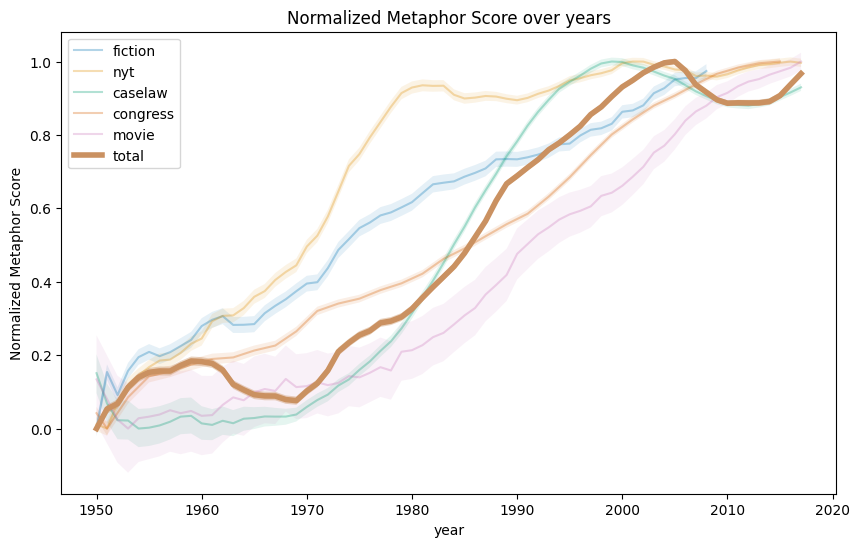

In [42]:
# cut after 2009 for fiction ds
total_plot_df = pd.read_csv(data_path+'implicit_pooling_plot.csv')
total_plot_df = total_plot_df[~((total_plot_df['dataset'] == 'fiction') & (total_plot_df['year'] >= 2009))]
plot_implicit_trend(total_plot_df)

# Plot by domain (object)

In [21]:
# load category map for object categories
with open('/zfs/projects/faculty/amirgo-management/code_review/3_feature_generation/implicit/fillmask_target_objects.json') as f:
    category_map = json.load(f)
category_map['lemmatized'].keys()

dict_keys(['subjectivity', 'body', 'relationship', 'relational_subjectivity'])

In [ ]:
def gen_group_category(df, category_map):
    # category_map: dictionary key --> list of objects
    # check primary object category: subjectivity, relationship, body
    subjectivity_words = category_map['lemmatized']['subjectivity']
    relationship_words = category_map['lemmatized']['relationship']
    body_words = category_map['lemmatized']['body']

    # for each object in each row, find the corresponding category
    df['object_category'] = df['object'].progress_apply(lambda x: 'subjectivity' if x in subjectivity_words else ('relationship' if x in relationship_words else ('body' if x in body_words else 'NAN')))

    # check relational subjectivity, a standalone category
    relational_subjectivity_words = category_map['lemmatized']['relational_subjectivity']
    df['if_relational_subjectivity'] = df.apply(lambda x: 1 if x['object'] in relational_subjectivity_words else 0, axis=1)
    return df

In [23]:
df = gen_group_category(df, category_map)

In [43]:
dataset_size_dict = df['dataset'].value_counts().to_dict()
dataset_size_dict['total'] = len(df)

In [24]:
# generate one plot per dataset
def plot_df_per_ds(df, dataset):
    plot_dfs = []
    if dataset != 'total':
        df = df[df['dataset'] == dataset]
    obj_categories = list(df['object_category'].unique())
    obj_categories = [x for x in obj_categories if x != 'NAN']
    for cat in tqdm(obj_categories):
        print("Processing object category: ", cat)
        df_dataset = df[df['object_category'] == cat].copy()
        # normalize the data
        fig, ax = plt.subplots(figsize=(5, 4))
        sns.lineplot(x='year', y='subgroup_orig_syn_ratio', data=df_dataset, ax=ax)
        plot_df = get_plot_data(fig)
        plot_df['category'] = cat
        plot_dfs.append(plot_df)
        plt.close(fig)
    total_plot_df = pd.concat(plot_dfs)
    return total_plot_df

In [25]:
plot_dfs_by_ds = []
datasets = list(df['dataset'].unique())
datasets.append('total')
for dataset in datasets:
    print("Processing dataset: ", dataset)
    plot_df = plot_df_per_ds(df, dataset)
    plot_df['dataset'] = dataset
    plot_dfs_by_ds.append(plot_df)
total_plot_df = pd.concat(plot_dfs_by_ds, ignore_index=True)

Processing dataset:  congress


  0%|          | 0/3 [00:00<?, ?it/s]

Processing object category:  relationship


 33%|███▎      | 1/3 [00:12<00:25, 12.61s/it]

Processing object category:  subjectivity


 67%|██████▋   | 2/3 [00:19<00:09,  9.52s/it]

Processing object category:  body


100%|██████████| 3/3 [00:24<00:00,  8.30s/it]


Processing dataset:  movie


  0%|          | 0/3 [00:00<?, ?it/s]

Processing object category:  relationship


 33%|███▎      | 1/3 [00:10<00:20, 10.35s/it]

Processing object category:  body


 67%|██████▋   | 2/3 [00:11<00:05,  5.00s/it]

Processing object category:  subjectivity


100%|██████████| 3/3 [00:14<00:00,  4.86s/it]


Processing dataset:  caselaw


  0%|          | 0/3 [00:00<?, ?it/s]

Processing object category:  relationship


 33%|███▎      | 1/3 [01:37<03:14, 97.34s/it]

Processing object category:  subjectivity


 67%|██████▋   | 2/3 [02:13<01:01, 61.55s/it]

Processing object category:  body


100%|██████████| 3/3 [02:28<00:00, 49.63s/it]


Processing dataset:  nyt


  0%|          | 0/3 [00:00<?, ?it/s]

Processing object category:  relationship


 33%|███▎      | 1/3 [01:36<03:12, 96.34s/it]

Processing object category:  subjectivity


 67%|██████▋   | 2/3 [02:12<01:00, 60.72s/it]

Processing object category:  body


100%|██████████| 3/3 [02:30<00:00, 50.07s/it]


Processing dataset:  fiction


  0%|          | 0/3 [00:00<?, ?it/s]

Processing object category:  relationship


 33%|███▎      | 1/3 [01:54<03:49, 114.60s/it]

Processing object category:  subjectivity


 67%|██████▋   | 2/3 [02:43<01:15, 75.71s/it] 

Processing object category:  body


100%|██████████| 3/3 [02:50<00:00, 56.79s/it]


Processing dataset:  total


  0%|          | 0/3 [00:00<?, ?it/s]

Processing object category:  relationship


 33%|███▎      | 1/3 [06:08<12:16, 368.10s/it]

Processing object category:  subjectivity


 67%|██████▋   | 2/3 [08:13<03:45, 225.62s/it]

Processing object category:  body


100%|██████████| 3/3 [08:59<00:00, 179.81s/it]


In [57]:
total_plot_df = pd.concat(plot_dfs_by_ds, ignore_index=True)
total_plot_df.to_csv(data_path+'implicit_pooling_plot_by_category.csv', index=False)

In [55]:
# plot different category with different hues within different datasets
def plot_implicit_trend_per_ds(total_plot_df):
    total_plot_df = total_plot_df[total_plot_df['year'] <= 2017]
    categories = ['subjectivity','body','relationship'] # a fixed sequence
    datasets = ['nyt','caselaw','congress','movie','fiction']
    datasets.append('total')
    # two rows, three columns, one figure per dataset
    fig, ax = plt.subplots(2, 3, figsize=(20, 10))
    for dataset in datasets:
        df_dataset = total_plot_df[total_plot_df['dataset'] == dataset]
        for category in categories:
            df_category = df_dataset[df_dataset['category'] == category]
            # color blind palette
            color = sns.color_palette("colorblind", len(categories))[categories.index(category)]
            ax[datasets.index(dataset)//3, datasets.index(dataset)%3].plot(df_category['year'], df_category['y_smooth'], label=category, color=color, alpha=0.7)
            ax[datasets.index(dataset)//3, datasets.index(dataset)%3].fill_between(df_category['year'], df_category['ci_lower_smooth'], df_category['ci_upper_smooth'], alpha=0.3)
            ax[datasets.index(dataset)//3, datasets.index(dataset)%3].legend()
            ax[datasets.index(dataset)//3, datasets.index(dataset)%3].set_xlabel('year')
            ax[datasets.index(dataset)//3, datasets.index(dataset)%3].set_ylabel('Implicit Metaphor Score')
            ax[datasets.index(dataset)//3, datasets.index(dataset)%3].set_title(f'{dataset} (n={dataset_size_dict[dataset]})')
    plt.suptitle("Implicit Metaphor Score over years", fontsize=16)

In [53]:
# cut after 2009 for fiction ds
total_plot_df = total_plot_df[~((total_plot_df['dataset'] == 'fiction') & (total_plot_df['year'] >= 2009))]

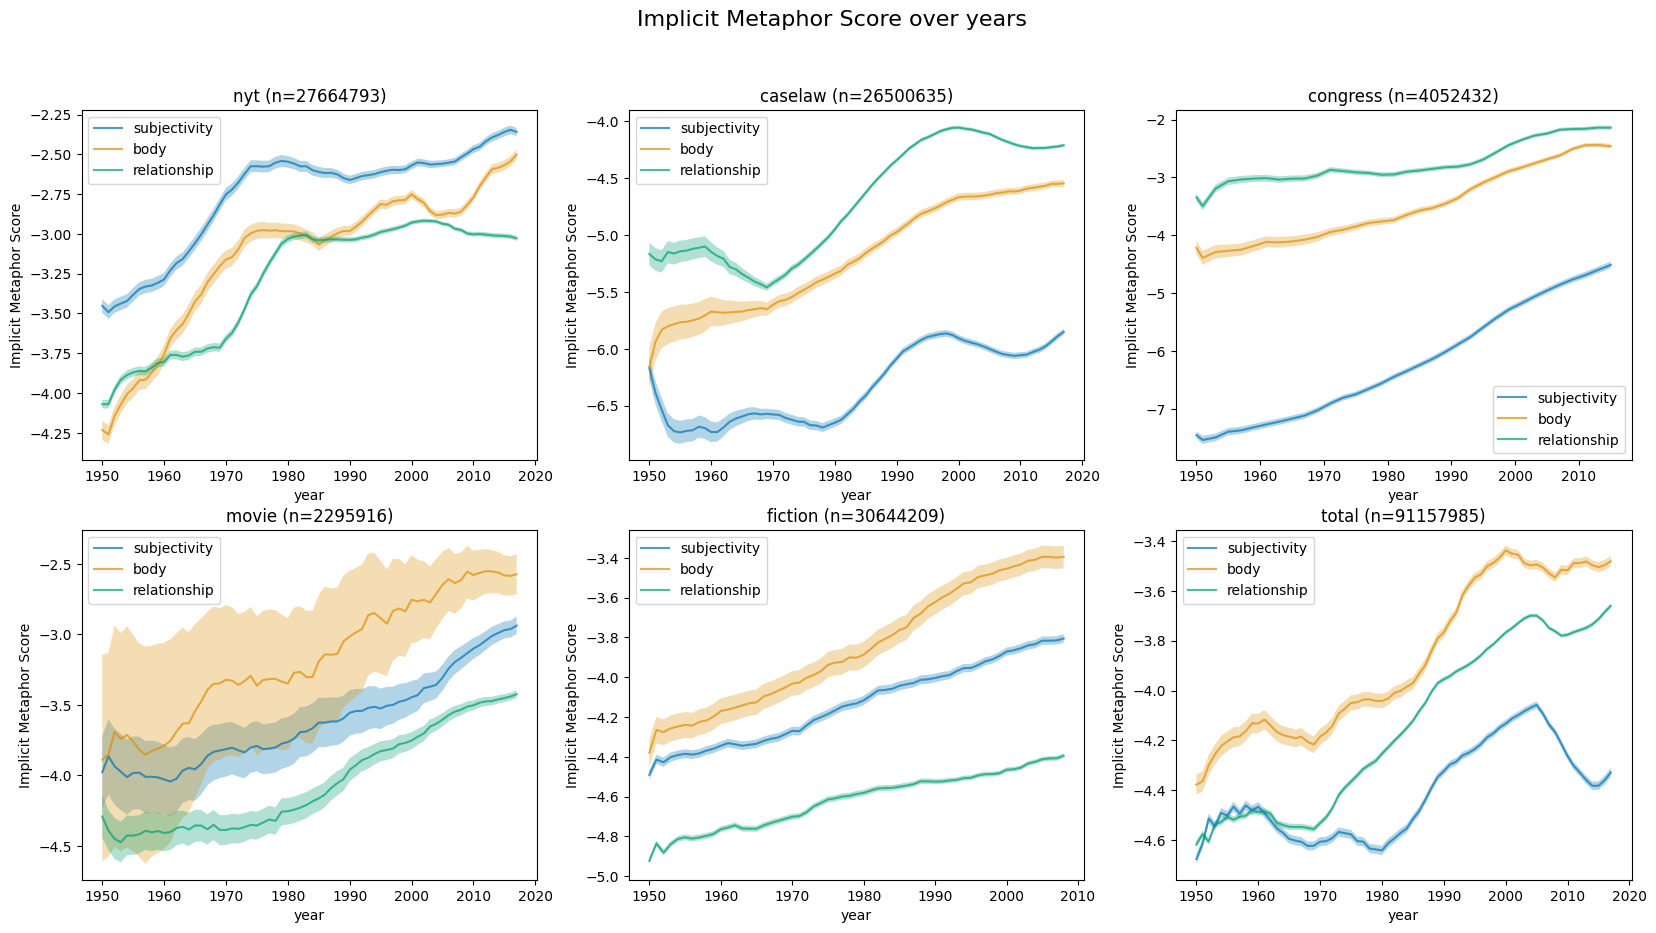

In [56]:
plot_implicit_trend_per_ds(total_plot_df)